# Setup

In [2]:
from utils import esg
from utils.ownership import parse_ownership_data
from utils.regressors import parse_regressors

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white",
        palette="pastel",
        color_codes=True,
        rc={ 'figure.figsize': (12, 9) })

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import collections

# Importing data

In [5]:
import dotenv, os

dotenv.load_dotenv()

data_path = os.path.join("..", os.environ.get("DATA_PATH"))

esg_path = os.path.join(data_path, "ESG.xlsx")
sheet_name = os.environ.get("SHEET_NAME")

own_path = os.path.join(data_path, "ownership.csv")
reg_path = os.path.join(data_path, "controls.csv")

saliency_path = os.path.join(data_path, "saliency.csv")

## Covariates

In [6]:
raw = pd.read_csv(reg_path)
covariates = parse_regressors(raw)

## ESG data

In [7]:
raw = pd.read_excel(esg_path, sheet_name = sheet_name)
get_esg = esg.yearly_esg_maker(raw)

## Ownership data

In [8]:
ownership = parse_ownership_data(pd.read_csv(own_path))
investors = ownership.columns[-7:]

In [9]:
ticker_to_name = dict(zip(ownership.TargetFirms, ownership.Tickers))

## Saliency data

In [78]:
saliency_df = pd.read_csv(saliency_path, index_col = [0, 1])

# Regression

In [85]:
def makeregressors(saliency_df, ownership, covariates):

    relevant_covariates = [col for col in covariates.columns if "Total Assets" not in col] # Remove redundant coviariate

    covariates = covariates[relevant_covariates]
    
    investors = [inv for inv in ownership.columns[-7:] if inv != "Generali"]
    total_ownership = ownership.loc[:, investors]
    total_ownership.columns = [investor.lower() for investor in investors]
    total_ownership.index = ownership['Tickers']

    total_saliency = saliency_df.sum()
    total_saliency /= total_saliency.sum() 
    
    SIO = []
    IO = []

    for firm in total_ownership.index:
        weighted_ownership = 0
        institutional_ownership = 0
        
        for investor in total_ownership.columns:
            weighted_ownership += total_ownership.loc[firm, investor] * total_saliency.loc[investor] 
            institutional_ownership += total_ownership.loc[firm, investor] / len(investors)

        SIO.append(weighted_ownership)
        IO.append(institutional_ownership)

    X = pd.DataFrame(
        {
            "SIO": SIO,
            "IO": IO
        }, 
        index = total_ownership.index)


    X = sm.add_constant(X, prepend = False, has_constant='add')

    common_indices = set(X.index).intersection(set(covariates.index))

    X = pd.concat([X.loc[common_indices], covariates.loc[common_indices]], axis = 1)

    # FIXME: Some firms have redundant ticker. I exclude them.
    single_ticker = [n for (n, c) in collections.Counter(X.index).items() if c == 1]
    X = X.loc[single_ticker]

    return X.astype(float)

In [86]:
X = makeregressors(saliency_df, ownership, covariates).dropna()

In [87]:
y = get_esg(2020)["Environment Pillar Score"] / 100
y.index = [ticker_to_name.get(f, "not found") for f in  y.index]
y = y.loc[y > 0]

common_indices = set(y.index).intersection(set(X.index))

y = y.loc[common_indices]
X = X.loc[common_indices]

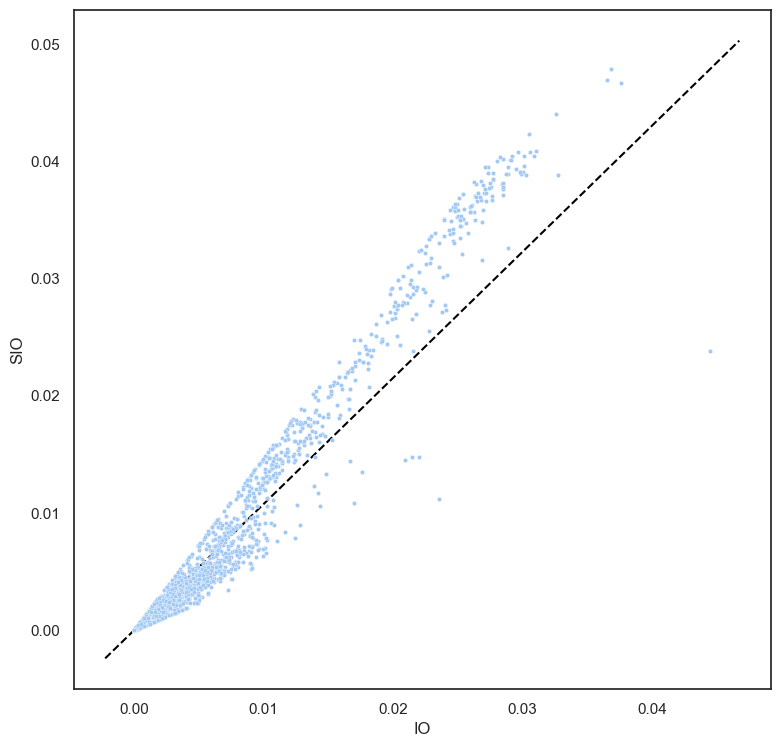

In [88]:
fig, ax = plt.subplots(dpi = 100, figsize = (9, 9))
sns.scatterplot(data = X, x = "IO", y = "SIO", zorder=1, s = 10)

ax.plot(ax.get_xlim(), ax.get_ylim(), linestyle = "dashed", color = "black", zorder=0)

In [89]:
sm.Logit(y, X.drop("SIO", axis = 1)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.650112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     Environment Pillar Score   No. Observations:                 1686
Model:                                Logit   Df Residuals:                     1670
Method:                                 MLE   Df Model:                           15
Date:                      Thu, 02 Dec 2021   Pseudo R-squ.:               -0.007015
Time:                              12:31:52   Log-Likelihood:                -1096.1
converged:                             True   LL-Null:                       -1088.5
Covariance Type:                  nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
IO                    -20.9339      7.077     -2.958      0.003     -34.804      -7.064
const                  -0.3461      0.101     -3.439      0.001      -0.543      -0.149
Leverage Ratio-2016    -0.0021      0.006     -0.384      0.701      -0.013       0.009
Total Debt-2016      1.068e-07   3.71e-07      0.288      0.774   -6.21e-07    8.35e-07
ROA-2016               -0.0008      0.005     -0.166      0.868      -0.011       0.009
PPE-2016             3.494e-06   2.22e-06      1.576      0.115   -8.51e-07    7.84e-06
Leverage Ratio-2017    -0.0005      0.009     -0.052      0.959      -0.018       0.017
Total Debt-2017     -1.447e-07   4.91e-07     -0.295      0.768   -1.11e-06    8.18e-07
ROA-2017                0.0076      0.006      1.170      0.242      -0.005       0.020
PPE-2017            -2.389e-06   2.63e-06     -0.907      0.365   -7.55e-06    2.77e-06
Leverage Ratio-2018     0.0045      0.008      0.563      0.574      -0.011       0.020
Total Debt-2018      2.954e-07   4.48e-07      0.659      0.510   -5.83e-07    1.17e-06
ROA-2018                0.0039      0.006      0.641      0.521      -0.008       0.016
PPE-2018            -5.297e-07   8.71e-07     -0.608      0.543   -2.24e-06    1.18e-06
Leverage Ratio-2019  5.731e-05      0.005      0.011      0.991      -0.010       0.010
Total Debt-2019     -2.356e-07   2.79e-07     -0.843      0.399   -7.83e-07    3.12e-07
=======================================================================================
"""

In [90]:
sm.Logit(y, X.drop("IO", axis = 1)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.645679
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     Environment Pillar Score   No. Observations:                 1686
Model:                                Logit   Df Residuals:                     1670
Method:                                 MLE   Df Model:                           15
Date:                      Thu, 02 Dec 2021   Pseudo R-squ.:              -0.0001480
Time:                              12:31:56   Log-Likelihood:                -1088.6
converged:                             True   LL-Null:                       -1088.5
Covariance Type:                  nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
SIO                   -22.5206      5.318     -4.235      0.000     -32.943     -12.098
const                  -0.3220      0.098     -3.281      0.001      -0.514      -0.130
Leverage Ratio-2016    -0.0024      0.006     -0.432      0.666      -0.013       0.008
Total Debt-2016       1.05e-07    3.7e-07      0.284      0.777   -6.21e-07    8.31e-07
ROA-2016               -0.0008      0.005     -0.156      0.876      -0.010       0.009
PPE-2016              3.46e-06   2.21e-06      1.566      0.117   -8.72e-07    7.79e-06
Leverage Ratio-2017     0.0001      0.009      0.014      0.988      -0.017       0.017
Total Debt-2017      -1.36e-07    4.9e-07     -0.277      0.781    -1.1e-06    8.25e-07
ROA-2017                0.0077      0.006      1.184      0.237      -0.005       0.020
PPE-2017            -2.403e-06   2.62e-06     -0.917      0.359   -7.54e-06    2.73e-06
Leverage Ratio-2018     0.0038      0.008      0.475      0.635      -0.012       0.020
Total Debt-2018      2.909e-07   4.48e-07      0.650      0.516   -5.87e-07    1.17e-06
ROA-2018                0.0036      0.006      0.603      0.547      -0.008       0.015
PPE-2018            -4.984e-07   8.61e-07     -0.579      0.563   -2.19e-06    1.19e-06
Leverage Ratio-2019     0.0009      0.005      0.170      0.865      -0.009       0.011
Total Debt-2019     -2.388e-07   2.79e-07     -0.857      0.392   -7.85e-07    3.07e-07
=======================================================================================
"""

In [91]:
sm.Logit(y, X).fit().summary()

Optimization terminated successfully.
         Current function value: 0.627193
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     Environment Pillar Score   No. Observations:                 1686
Model:                                Logit   Df Residuals:                     1669
Method:                                 MLE   Df Model:                           16
Date:                      Thu, 02 Dec 2021   Pseudo R-squ.:                 0.02849
Time:                              12:32:01   Log-Likelihood:                -1057.4
converged:                             True   LL-Null:                       -1088.5
Covariance Type:                  nonrobust   LLR p-value:                 2.390e-07
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
SIO                  -190.2611     29.184     -6.519      0.000    -247.461    -133.061
IO                    233.9574     39.954      5.856      0.000     155.649     312.266
const                  -0.5861      0.109     -5.397      0.000      -0.799      -0.373
Leverage Ratio-2016    -0.0036      0.006     -0.621      0.535      -0.015       0.008
Total Debt-2016      1.439e-07   3.73e-07      0.386      0.699   -5.87e-07    8.74e-07
ROA-2016               -0.0001      0.005     -0.026      0.979      -0.010       0.009
PPE-2016              3.24e-06   2.21e-06      1.468      0.142   -1.08e-06    7.57e-06
Leverage Ratio-2017     0.0019      0.009      0.206      0.837      -0.016       0.019
Total Debt-2017     -1.823e-07   4.93e-07     -0.370      0.711   -1.15e-06    7.83e-07
ROA-2017                0.0061      0.006      0.994      0.320      -0.006       0.018
PPE-2017             -2.22e-06   2.63e-06     -0.844      0.399   -7.38e-06    2.94e-06
Leverage Ratio-2018     0.0039      0.008      0.480      0.631      -0.012       0.020
Total Debt-2018      2.734e-07   4.47e-07      0.611      0.541   -6.03e-07    1.15e-06
ROA-2018                0.0023      0.006      0.389      0.697      -0.009       0.014
PPE-2018            -4.735e-07   8.75e-07     -0.541      0.589   -2.19e-06    1.24e-06
Leverage Ratio-2019     0.0005      0.005      0.094      0.925      -0.010       0.011
Total Debt-2019     -2.122e-07   2.78e-07     -0.764      0.445   -7.57e-07    3.33e-07
=======================================================================================
"""